# Apache Spark: SparkSQL

## Introduction

SparkSQL can be used to access Spark DataFrames using SQL. By default SparkSQL uses ANSI SQL and we will be using that throughout this and future notebookes. We can do the same things that we did in the Initial Analysis using SparkSQL. This Notebook will follow the same analysis as the Initial Analysis Notebook, but will use SparkSQL.

## Setup

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T

import matplotlib.pyplot as plt
%matplotlib inline

spark = SparkSession.\
    builder.\
    appName('test').\
    getOrCreate()

# The following sets up the ability to output a nicely formatted table.
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

## Load the Data

The following cell reads a Parquet file into a Spark DataFrame and then prints out the schema of the DataFrame. This notebook uses the clean version of the parquet file that was created in the Initial Analysis notebook.

In [2]:
df = spark.read.parquet('/home/jovyan/work/Taxi_Trips_SF_20250621_clean.parquet')

df.printSchema()

root
 |-- vehicle_placard_number: string (nullable = true)
 |-- driver_id: string (nullable = true)
 |-- start_time_local: timestamp (nullable = true)
 |-- end_time_local: timestamp (nullable = true)
 |-- pickup_location_latitude: double (nullable = true)
 |-- pickup_location_longitude: double (nullable = true)
 |-- pickup_location: string (nullable = true)
 |-- dropoff_location_latitude: double (nullable = true)
 |-- dropoff_location_longitude: double (nullable = true)
 |-- dropoff_location: string (nullable = true)
 |-- hail_type: string (nullable = true)
 |-- paratransit: integer (nullable = true)
 |-- sfo_pickup: integer (nullable = true)
 |-- qa_flags: string (nullable = true)
 |-- fare_type: string (nullable = true)
 |-- meter_fare_amount: double (nullable = true)
 |-- upfront_pricing: double (nullable = true)
 |-- promo_rate: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- sf_exit_fee: double (nullable = true)
 |-- other_fees: double (nullable = true)
 |-- tip

## Create a Temp View on the DataFrame

The createOrReplaceTempView() method to create a view on the DataFrame that can be used in SparkSQL to refer to the DataFrame.

In [3]:
df.createOrReplaceTempView('rides')

In [4]:
spark.sql("""
select    count(1) as count
from      rides
""").limit(10) # The limit will cause this to print out nicely formatted.

count
4129083


## Count the Number of Trips by Driver

The following cell will count the number of trips taken by each driver.

In [5]:
df2 = spark.sql("""
select   driver_id, count(1) as driver_cnt
from     rides
group by driver_id
order by driver_cnt desc;
""")
df2.limit(10)

driver_id,driver_cnt
-,64743
D-6944,13395
A-9919,12858
D-4689,12740
D-9523,12551
D-7904,12514
E-6625,12354
D-7557,11818
C-8494,11599
C-4842,11406


## Plot the Data

Data can be plotted using matplotlib.

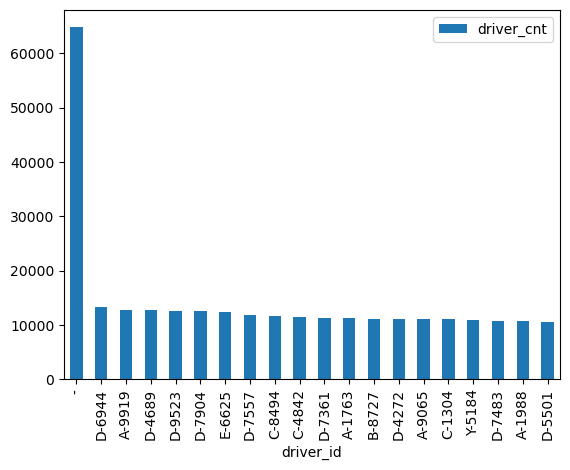

In [6]:
df2 = df2.limit(20).toPandas()
df2.plot(kind="bar", x="driver_id", y="driver_cnt")
plt.show()

## Calculate the Average Number of Trips per Driver

The following cell will calculate the average number of trips per driver using the Spark avg function.

In [7]:
spark.sql("""
with x as (
select    driver_id, count(1) as driver_cnt
from      rides
group by  driver_id
)
select    round(avg(driver_cnt), 2) as avg_trips_per_driver
from      x
""").limit(10)

avg_trips_per_driver
2955.68


## Count the Distinct Number of Drivers

In [8]:
spark.sql("""
select   count(distinct driver_id) as driver_count
from     rides;
""")

driver_count
1397


## Count the Distinct Drivers by Month

In [9]:
df3 = spark.sql("""
select    trunc(to_timestamp(start_time_local, 'y/M/d h:m:s a'), 'month') month, count(distinct driver_id) driver_cnt
from      rides
group by  trunc(to_timestamp(start_time_local, 'y/M/d h:m:s a'), 'month')
order by  trunc(to_timestamp(start_time_local, 'y/M/d h:m:s a'), 'month');
""")
df3.limit(10)

month,driver_cnt
2022-12-01,932
2023-01-01,916
2023-02-01,924
2023-03-01,948
2023-04-01,961
2023-05-01,965
2023-06-01,969
2023-07-01,970
2023-08-01,988
2023-09-01,972


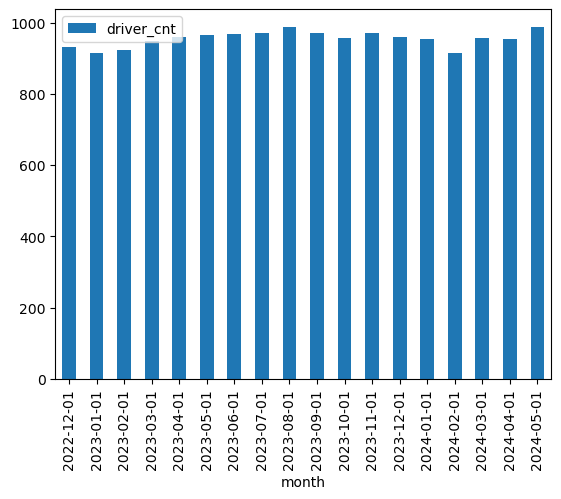

In [10]:
df3 = df3.limit(20).toPandas()
df3.plot(kind="bar", x="month", y="driver_cnt")
plt.show()

In [11]:
df4 = spark.sql("""
select    trunc(to_timestamp(start_time_local, 'y/M/d h:m:s a'), 'month') month, count(distinct driver_id) driver_cnt
from      rides
group by  trunc(to_timestamp(start_time_local, 'y/M/d h:m:s a'), 'month')
order by  driver_cnt desc;
""")
df4.limit(10)

month,driver_cnt
2023-08-01,988
2024-05-01,988
2023-09-01,972
2023-11-01,972
2023-07-01,970
2023-06-01,969
2023-05-01,965
2023-04-01,961
2023-12-01,959
2024-03-01,956


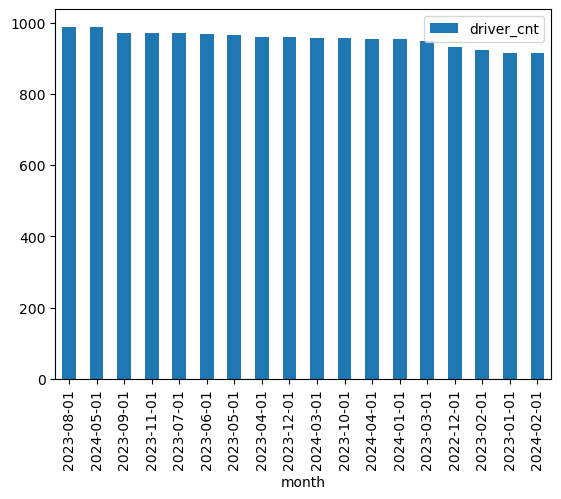

In [12]:
df4 = df4.limit(20).toPandas()
df4.plot(kind="bar", x="month", y="driver_cnt")
plt.show()

## Count the Vehicles Per Month

Now let's count the vehicle_placard_numbers per month ordered by month, then ordered by count.

In [13]:
df5 = spark.sql("""
select    trunc(to_timestamp(start_time_local, 'y/M/d h:m:s a'), 'month') month, count(distinct vehicle_placard_number) vehicle_cnt
from      rides
group by  trunc(to_timestamp(start_time_local, 'y/M/d h:m:s a'), 'month')
order by  trunc(to_timestamp(start_time_local, 'y/M/d h:m:s a'), 'month');
""")
df5.limit(10)

month,vehicle_cnt
2022-12-01,751
2023-01-01,746
2023-02-01,772
2023-03-01,768
2023-04-01,779
2023-05-01,807
2023-06-01,805
2023-07-01,804
2023-08-01,819
2023-09-01,822


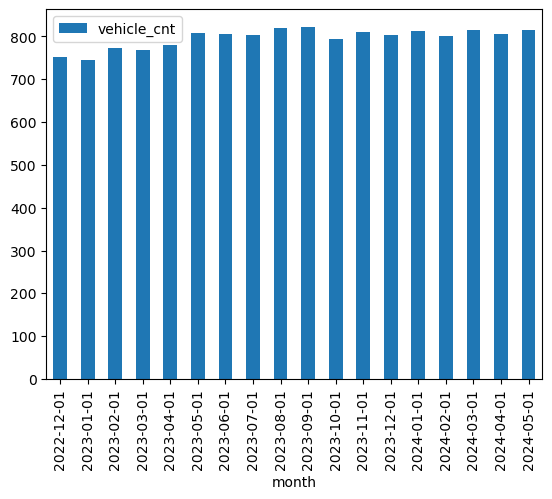

In [14]:
df5 = df5.limit(20).toPandas()
df5.plot(kind="bar", x="month", y="vehicle_cnt")
plt.show()

In [15]:
df6 = spark.sql("""
select    trunc(to_timestamp(start_time_local, 'y/M/d h:m:s a'), 'month') month, count(distinct vehicle_placard_number) vehicle_cnt
from      rides
group by  trunc(to_timestamp(start_time_local, 'y/M/d h:m:s a'), 'month')
order by  vehicle_cnt desc;
""")
df6.limit(10)

month,vehicle_cnt
2023-09-01,822
2023-08-01,819
2024-03-01,816
2024-05-01,815
2024-01-01,813
2023-11-01,811
2023-05-01,807
2024-04-01,806
2023-06-01,805
2023-12-01,804


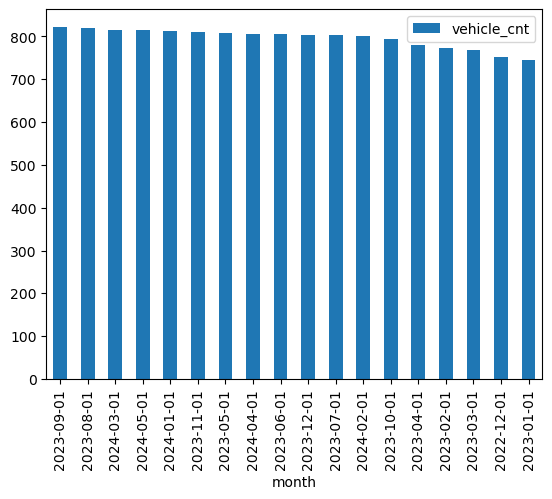

In [16]:
df6 = df6.limit(20).toPandas()
df6.plot(kind="bar", x="month", y="vehicle_cnt")
plt.show()

## Count the Number of Rides by Month

In [26]:
df7 = spark.sql("""
select    trunc(to_timestamp(start_time_local, 'y/M/d h:m:s a'), 'month') month, count(1) monthly_rides
from      rides
group by  trunc(to_timestamp(start_time_local, 'y/M/d h:m:s a'), 'month')
order by  trunc(to_timestamp(start_time_local, 'y/M/d h:m:s a'), 'month');
""")
df7.limit(10)

month,monthly_rides
2022-12-01,192935
2023-01-01,212798
2023-02-01,189659
2023-03-01,208091
2023-04-01,218564
2023-05-01,209450
2023-06-01,209284
2023-07-01,204971
2023-08-01,221375
2023-09-01,211829


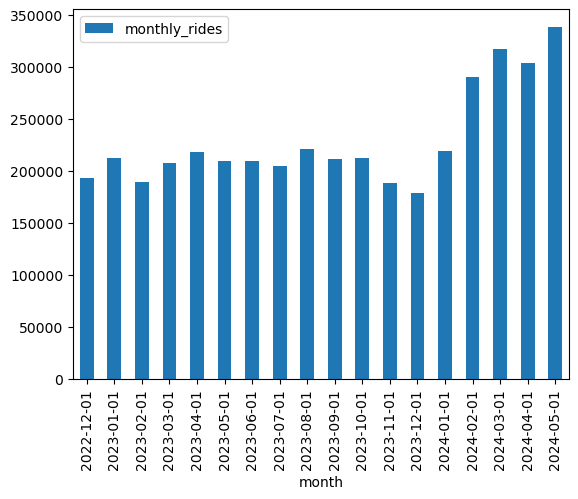

In [27]:
df7 = df7.limit(20).toPandas()
df7.plot(kind="bar", x="month", y="monthly_rides")
plt.show()

In [36]:
df8 = spark.sql("""
select    trunc(to_timestamp(start_time_local, 'y/M/d h:m:s a'), 'month') month, count(1) monthly_rides
from      rides
group by  trunc(to_timestamp(start_time_local, 'y/M/d h:m:s a'), 'month')
order by  monthly_rides desc;
""")
df8.limit(10)

month,monthly_rides
2024-05-01,338585
2024-03-01,317683
2024-04-01,304343
2024-02-01,290231
2023-08-01,221375
2024-01-01,219687
2023-04-01,218564
2023-01-01,212798
2023-10-01,212373
2023-09-01,211829


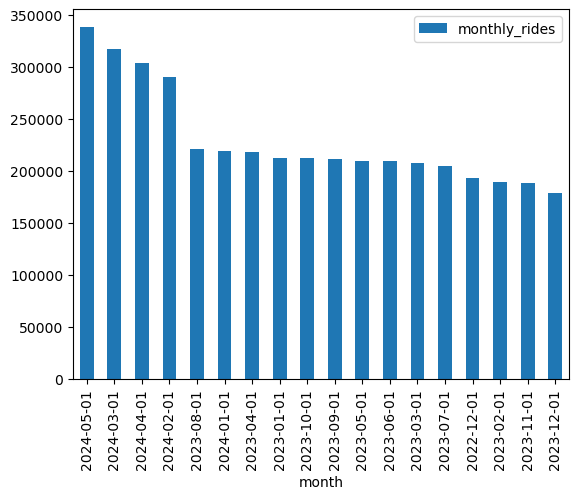

In [37]:
df8 = df8.limit(20).toPandas()
df8.plot(kind="bar", x="month", y="monthly_rides")
plt.show()

## Count the Number of Trips by Vehicle

In [32]:
df9 = spark.sql("""
select   vehicle_placard_number, count(1) trip_count
from     rides
group by vehicle_placard_number
order by trip_count desc;
""")
df9.limit(10)

vehicle_placard_number,trip_count
0740,17333
1410,16021
0033,15946
0784,15603
1314,15088
1069,14630
1068,14248
1173,13307
2168,12778
1106,12246


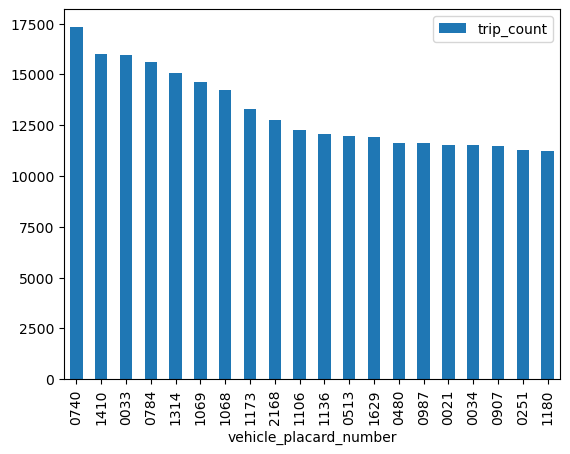

In [33]:
df10 = df10.limit(20).toPandas()
df10.plot(kind="bar", x="vehicle_placard_number", y="trip_count")
plt.show()

## Count the Number of Rides by Driver by Month

In [19]:
spark.sql("""
select    trunc(to_timestamp(start_time_local, 'y/M/d h:m:s a'), 'month') month, driver_id, count(1) monthly_rides
from      rides
group by  trunc(to_timestamp(start_time_local, 'y/M/d h:m:s a'), 'month'), driver_id
order by  trunc(to_timestamp(start_time_local, 'y/M/d h:m:s a'), 'month'), driver_id;
""").limit(20)

month,driver_id,monthly_rides
2022-12-01,-,1667
2022-12-01,1-9999,12
2022-12-01,6-9431,108
2022-12-01,9-6938,263
2022-12-01,A-0051,115
2022-12-01,A-0067,33
2022-12-01,A-0071,73
2022-12-01,A-0163,356
2022-12-01,A-0230,71
2022-12-01,A-0244,367


In [20]:
spark.sql("""
select    trunc(to_timestamp(start_time_local, 'y/M/d h:m:s a'), 'month') month, driver_id, count(1) monthly_rides
from      rides
group by  trunc(to_timestamp(start_time_local, 'y/M/d h:m:s a'), 'month'), driver_id
order by  monthly_rides desc;
""").limit(20)

month,driver_id,monthly_rides
2023-01-01,-,28044
2023-02-01,-,14765
2024-02-01,-,6801
2024-02-01,D-4689,1885
2022-12-01,-,1667
2024-05-01,C-4064,1595
2024-05-01,B-5873,1593
2024-04-01,C-4064,1538
2024-03-01,C-4064,1536
2023-03-01,-,1467


## The explain() Method

The explain() method shows the execution plan for the DataFrame. When called without paramters, it will show the Physical Plan.

I will not delve into a deep explaination of the physical plan or Spark performance tuning here, but note that the exchange steps require shuffles, which is one of the most expensive actions in Spark.

In [21]:

df11 = spark.sql("""
select    trunc(to_timestamp(start_time_local, 'y/M/d h:m:s a'), 'month') month, driver_id, count(1) monthly_rides
from      rides
group by  trunc(to_timestamp(start_time_local, 'y/M/d h:m:s a'), 'month'), driver_id
order by  trunc(to_timestamp(start_time_local, 'y/M/d h:m:s a'), 'month'), driver_id;
""")

In [22]:
df11.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Sort [month#432 ASC NULLS FIRST, driver_id#1 ASC NULLS FIRST], true, 0
   +- Exchange rangepartitioning(month#432 ASC NULLS FIRST, driver_id#1 ASC NULLS FIRST, 200), ENSURE_REQUIREMENTS, [plan_id=2331]
      +- HashAggregate(keys=[_groupingexpression#438, driver_id#1], functions=[count(1)])
         +- Exchange hashpartitioning(_groupingexpression#438, driver_id#1, 200), ENSURE_REQUIREMENTS, [plan_id=2328]
            +- HashAggregate(keys=[_groupingexpression#438, driver_id#1], functions=[partial_count(1)])
               +- Project [driver_id#1, trunc(cast(gettimestamp(start_time_local#2, y/M/d h:m:s a, TimestampType, Some(Etc/UTC), false) as date), month) AS _groupingexpression#438]
                  +- FileScan parquet [driver_id#1,start_time_local#2] Batched: true, DataFilters: [], Format: Parquet, Location: InMemoryFileIndex(1 paths)[file:/home/jovyan/work/Taxi_Trips_SF_20250621_clean.parquet], PartitionFilters: [], Pushe

## Conclusion

SparkSQL allows the use of ANSI (by default) SQL to write queries against Spark data frames.

In the next notebook, I will use Spark SQL to complete further analysis on the SF Taxi Trips data set.